In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

In [3]:
# debugging
pd.set_option('display.max_rows', 50)

In [4]:
# read data from input
training_df = pd.read_csv('..\\Resources\\train.csv')
N = len(training_df.index)

In [5]:
training_df

,id,raw_address,POI/street
0,0,jl kapuk timur delta sili iii lippo cika 11 a ...,/jl kapuk timur delta sili iii lippo cika
1,1,"aye, jati sampurna",/
2,2,setu siung 119 rt 5 1 13880 cipayung,/siung
3,3,"toko dita, kertosono",toko dita/
4,4,jl. orde baru,/jl. orde baru
...,...,...,...
299995,299995,jend ahmad yani 331 kertasari ciamis,/jend ahmad yani
299996,299996,"raya cila kko, cilandak timur kel.",/raya cila kko
299997,299997,tanjung gusta jl. yaya 2 no 17,/
299998,299998,jalan cipadu jaya taman asri gang bijaksana 3 ...,taman asri/


Preprocessing
-------------
Convert addresses into usable vectors

In [6]:
# env variables for preprocessing
num_words = 100000
max_length = 50 # should be even
max_label_length = int(max_length / 2)
trunc_type='pre'
padding_type='pre'
oov_tok = "<OOV>"

In [7]:
# filter training and testing data
training_sentences = training_df['raw_address'].values

raw_labels = training_df['POI/street'].values
training_labels = np.array([tuple(s.split('/')) for s in raw_labels])

In [8]:
# initialize tokenizers
# main tokenizer for training data
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

# tokenizer for training labels
label_tokenizer = Tokenizer(num_words=num_words, oov_token=oov_tok)
label_tokenizer.fit_on_texts(training_labels.flat)

word_index = {**tokenizer.word_index, **label_tokenizer.word_index}

In [9]:
# function for converting to sequences (tokenization + padding)
def convert(sentences):
    converted_sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(converted_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)
    return padded_sequences
def convert_labels(labels):
    converted_labels = [label_tokenizer.texts_to_sequences(label) for label in labels]
    padded_labels = [pad_sequences(label, padding=padding_type, truncating=trunc_type, maxlen=max_label_length) for label in converted_labels]
    return np.array([np.concatenate(label_pair) for label_pair in padded_labels])

In [10]:
# convert training data
converted_training_sequences = convert(training_sentences)
converted_training_labels = convert_labels(training_labels)

ML Model
-------------

In [11]:
# debugging plot graph
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [12]:
# ml env variables
num_of_epochs = 100
validation_split = 0.2
embedding_dim = 30

In [13]:
# prep data into batches
x = np.array([converted_training_sequences])
y = np.array([converted_training_labels])

x_shape = x[0][0].shape
y_shape = y[0][0].shape

In [14]:
# model - basic straightforward model
model_base = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(15, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(y_shape[0], activation='softmax')
])

opt = 'adam'
model_base.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 30)            3000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 30)            5520      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                8160      
_________________________________________________________________
dense (Dense)                (None, 50)                2050      
Total params: 3,015,730
Trainable params: 3,015,730
Non-trainable params: 0
_________________________________________________________________


In [15]:
# run model
history_base = model_base.fit(converted_training_sequences, converted_training_labels, epochs=num_of_epochs, validation_split=validation_split)

Epoch 1/50
7500/7500 [==============================] - 168s 22ms/step - loss: 4440119331.6215 - accuracy: 0.1771 - val_loss: 21176217600.0000 - val_accuracy: 0.1792
Epoch 2/50
6268/7500 [========================>.....] - ETA: 24s - loss: 22107255277.2125 - accuracy: 0.1768

KeyboardInterrupt: 

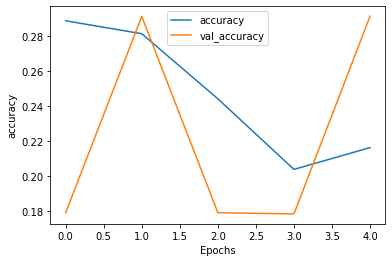

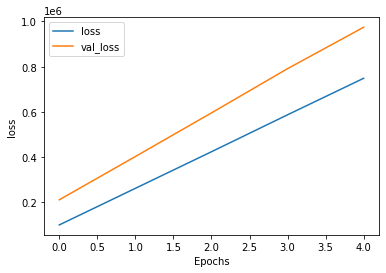

In [28]:
# debugging: show progression of model
plot_graphs(history_base, "accuracy")
plot_graphs(history_base, "loss")

Encoding <-> Decoding Model (WIP)
--------------------------------

In [20]:
# model - encoder <-> decoder
# (source: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

latent_dim = x_shape[0]

# encoder
encoder_inputs = tf.keras.layers.Input(shape=x_shape)
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(x)
encoder_states = [state_h, state_c]

# decoder
decoder_inputs = Input(shape=y_shape)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# compile into model
enc_dec_model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
enc_dec_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
enc_dec_model.summary()

InvalidArgumentError: cannot compute MatMul as input #1(zero-based) was expected to be a int32 tensor but is a float tensor [Op:MatMul]

In [ ]:
# run model - enc_dec_model
enc_dec_history = enc_dec_model.fit(converted_training_sequences, converted_training_labels, epochs=num_of_epochs, validation_split=validation_split)

In [ ]:
# debugging: show progression of enc_dec_model
plot_graphs(enc_dec_history, "accuracy")
plot_graphs(enc_dec_history, "loss")